# AI vs Human Content Detection

Este notebook implementa múltiples modelos de ML para detectar si un texto fue generado por IA o escrito por humanos.

## Estrategia:
1. **Baseline rápido:** Logistic Regression
2. **Modelo principal:** XGBoost con GridSearch
3. **Comparación:** Random Forest
4. **Deep Learning:** PyTorch Neural Network
5. **NLP Transformer:** DistilBERT fine-tuning para texto crudo
6. **Ensemble:** Combinación de los mejores modelos


## 1. Imports y Configuración

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import xgboost as xgb
import lightgbm as lgb

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
RANDOM_STATE = 42

# Detectar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🎮 PyTorch usando: {device}')
if torch.cuda.is_available():
    print(f'   GPU: {torch.cuda.get_device_name(0)}')
    print(f'   Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

# Detectar si XGBoost puede usar GPU
use_gpu_xgb = torch.cuda.is_available()
if use_gpu_xgb:
    print(f'🚀 XGBoost usará GPU (tree_method=gpu_hist)')
else:
    print(f'💻 XGBoost usará CPU (tree_method=hist)')

🎮 PyTorch usando: cuda
   GPU: NVIDIA GeForce RTX 3090
   Memoria disponible: 25.30 GB
🚀 XGBoost usará GPU (tree_method=gpu_hist)


### 🎮 Resumen de Aceleración GPU

Este notebook está optimizado para usar GPU cuando esté disponible:

| Modelo | GPU Support | Aceleración |
|--------|-------------|-------------|
| **Logistic Regression** | ❌ No | CPU only (scikit-learn) |
| **XGBoost** | ✅ Sí | `tree_method='gpu_hist'` |
| **Random Forest** | ❌ No | CPU only (scikit-learn) |
| **PyTorch NN** | ✅ Sí | `.to(device)` automático |
| **DistilBERT Transformer** | ✅ Sí | Fine-tuning acelerado con HuggingFace Trainer |
| **Ensemble** | ⚠️ Parcial | Usa GPU en XGBoost |

**Beneficios de GPU:**
- XGBoost: 5-10x más rápido con GPU
- PyTorch: 10-50x más rápido con GPU (depende del tamaño del modelo)
- DistilBERT: Fine-tuning mucho más rápido + mixed precision con GPU

**Si no tienes GPU:** El notebook funcionará perfectamente en CPU.


## 2. Carga y Exploración de Datos

In [32]:
# Cargar dataset
df = pd.read_csv('ai_human_content_detection_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nPrimeras filas:")
df.head()

Dataset shape: (1367, 17)

Columnas: ['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label']

Primeras filas:


,text_content,content_type,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
0,Score each cause. Quality throughout beautiful...,academic_paper,288,1927,54,0.9514,5.33,5.69,0.0280,53.08,7.41,1,0.1041,105.86,0.5531,0.2034,1
1,Board its rock. Job worker break tonight coupl...,essay,253,1719,45,0.9723,5.62,5.80,0.0262,50.32,8.10,6,0.2045,100.29,0.5643,0.4854,1
2,Way debate decision produce. Dream necessary c...,academic_paper,420,2849,75,0.9071,5.60,5.79,0.0263,46.86,7.86,5,0.2308,96.88,0.4979,-0.2369,1
3,Story turn because such during open model. Tha...,creative_writing,196,1310,34,0.9592,5.76,5.69,0.0260,53.80,7.00,2,0.1912,88.79,0.6241,NaN,1
4,Place specific as simply leader fall analysis....,news_article,160,1115,28,0.9688,5.71,5.97,0.0251,44.53,8.29,0,0.1318,26.15,0.2894,NaN,1


In [33]:
# Información del dataset
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
df.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_content          1367 non-null   object 
 1   content_type          1367 non-null   object 
 2   word_count            1367 non-null   int64  
 3   character_count       1367 non-null   int64  
 4   sentence_count        1367 non-null   int64  
 5   lexical_diversity     1367 non-null   float64
 6   avg_sentence_length   1367 non-null   float64
 7   avg_word_length       1367 non-null   float64
 8   punctuation_ratio     1367 non-null   float64
 9   flesch_reading_ease   1288 non-null   float64
 10  gunning_fog_index     1332 non-null   float64
 11  grammar_errors        1367 non-null   int64  
 12  passive_voice_ratio   1336 non-null   float64
 13  predictability_score  1367 non-null   float64
 14  burstiness            1367 non-null   float64
 

,word_count,character_count,sentence_count,lexical_diversity,avg_sentence_length,avg_word_length,punctuation_ratio,flesch_reading_ease,gunning_fog_index,grammar_errors,passive_voice_ratio,predictability_score,burstiness,sentiment_score,label
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1288.000000,1332.000000,1367.000000,1336.000000,1367.000000,1367.000000,1313.000000,1367.000000
mean,140.190929,940.329188,25.610095,0.967646,5.486423,5.717783,0.027440,52.183377,7.556877,1.537674,0.150198,62.779049,0.427041,-0.007997,0.499634
std,97.410218,654.335255,17.867480,0.026254,0.447202,0.279636,0.002801,10.466570,1.866676,1.912012,0.056738,28.223550,0.199249,0.588354,0.500183
min,3.000000,14.000000,1.000000,0.875000,3.000000,4.000000,0.019400,-50.010000,1.200000,0.000000,0.050000,20.030000,0.101100,-0.999300,0.000000
25%,61.500000,410.500000,11.000000,0.951550,5.270000,5.590000,0.026100,47.712500,6.620000,0.000000,0.099675,39.015000,0.250000,-0.525800,0.000000
50%,131.000000,882.000000,24.000000,0.969200,5.480000,5.710000,0.027200,52.190000,7.515000,1.000000,0.151350,56.820000,0.408500,-0.006200,0.000000
75%,193.000000,1294.500000,35.000000,0.989100,5.700000,5.830000,0.028400,57.322500,8.390000,3.000000,0.200150,86.645000,0.594300,0.502800,1.000000
max,443.000000,2966.000000,83.000000,1.000000,8.000000,8.330000,0.071400,98.870000,27.870000,10.000000,0.250000,119.930000,0.799500,0.995900,1.000000


Distribución de labels:
label
0    684
1    683
Name: count, dtype: int64

Porcentaje AI (1): 49.96%
Porcentaje Human (0): 50.04%


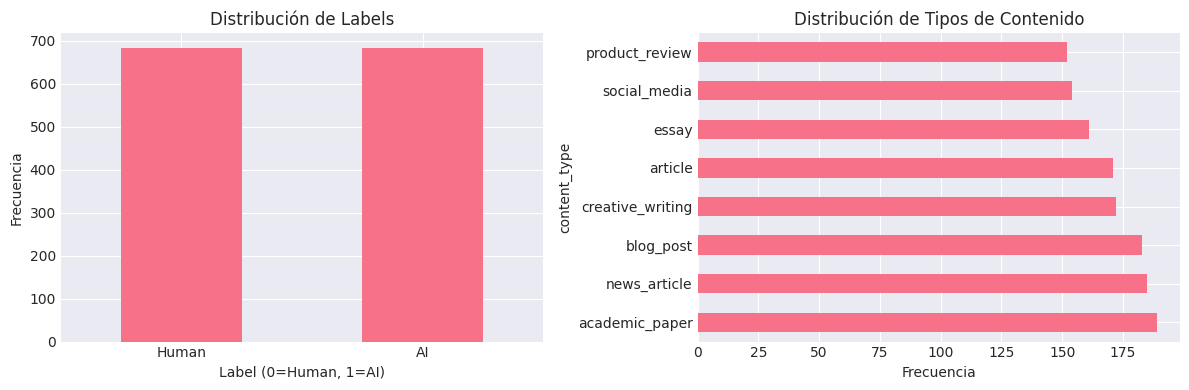

In [34]:
# Distribución de labels
print("Distribución de labels:")
print(df['label'].value_counts())
print(f"\nPorcentaje AI (1): {df['label'].mean()*100:.2f}%")
print(f"Porcentaje Human (0): {(1-df['label'].mean())*100:.2f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['label'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribución de Labels')
axes[0].set_xlabel('Label (0=Human, 1=AI)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['Human', 'AI'], rotation=0)

df['content_type'].value_counts().plot(kind='barh', ax=axes[1])
axes[1].set_title('Distribución de Tipos de Contenido')
axes[1].set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

In [35]:
# Valores faltantes
print("Valores faltantes por columna:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing'] > 0])

Valores faltantes por columna:
                     Missing  Percentage
flesch_reading_ease       79    5.779078
gunning_fog_index         35    2.560351
passive_voice_ratio       31    2.267740
sentiment_score           54    3.950256


## 3. Preprocesamiento de Datos

In [36]:
# Seleccionar solo features numéricas (excluir text_content y content_type)
feature_columns = [
    'word_count', 'character_count', 'sentence_count', 'lexical_diversity',
    'avg_sentence_length', 'avg_word_length', 'punctuation_ratio',
    'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors',
    'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score'
]

# Verificar qué columnas existen realmente
available_features = [col for col in feature_columns if col in df.columns]
print(f"Features disponibles: {len(available_features)}/{len(feature_columns)}")
print(available_features)

# Preparar X e y
X = df[available_features].copy()
y = df['label'].copy()

# Manejar valores faltantes (rellenar con mediana)
X = X.fillna(X.median())

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nValores faltantes restantes en X: {X.isnull().sum().sum()}")

Features disponibles: 14/14
['word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score']

Shape de X: (1367, 14)
Shape de y: (1367,)

Valores faltantes restantes en X: 0


In [37]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nDistribución en train: {y_train.value_counts().to_dict()}")
print(f"Distribución en test: {y_test.value_counts().to_dict()}")

Training set: (1093, 14)
Test set: (274, 14)

Distribución en train: {0: 547, 1: 546}
Distribución en test: {0: 137, 1: 137}


In [38]:
# Escalar features (importante para Logistic Regression y PyTorch)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features escaladas correctamente")
print(f"Media train (debe ser ~0): {X_train_scaled.mean(axis=0)[:3]}")
print(f"Std train (debe ser ~1): {X_train_scaled.std(axis=0)[:3]}")

Features escaladas correctamente
Media train (debe ser ~0): [-1.21890908e-16  4.22555149e-17  6.01328482e-17]
Std train (debe ser ~1): [1. 1. 1.]


## 4. Baseline: Logistic Regression

In [39]:
print("=" * 50)
print("MODELO 1: LOGISTIC REGRESSION (TUNED)")
print("=" * 50)

# Definir grid de hiperparámetros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

# GridSearch
print("Iniciando GridSearch para Logistic Regression...")
grid_lr = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE, max_iter=1000), 
    param_grid_lr, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)
grid_lr.fit(X_train_scaled, y_train)

# Mejor modelo
lr_model = grid_lr.best_estimator_
print(f"✅ Mejores parámetros LR: {grid_lr.best_params_}")

# Predicciones
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Human', 'AI']))

MODELO 1: LOGISTIC REGRESSION (TUNED)
Iniciando GridSearch para Logistic Regression...
✅ Mejores parámetros LR: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Accuracy: 0.5547
Precision: 0.5547
Recall: 0.5547
F1-Score: 0.5547
ROC-AUC: 0.5528

Classification Report:
              precision    recall  f1-score   support

       Human       0.55      0.55      0.55       137
          AI       0.55      0.55      0.55       137

    accuracy                           0.55       274
   macro avg       0.55      0.55      0.55       274
weighted avg       0.55      0.55      0.55       274



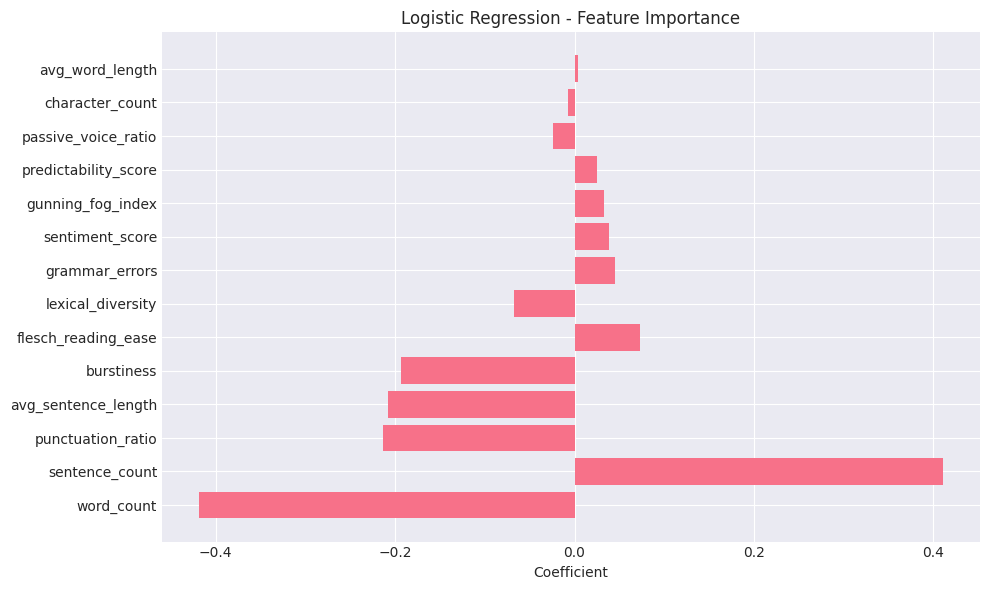


Top 5 features más importantes:
                feature  coefficient
0            word_count    -0.418341
2        sentence_count     0.410642
6     punctuation_ratio    -0.213823
4   avg_sentence_length    -0.207979
12           burstiness    -0.193701


In [40]:
# Feature importance para Logistic Regression
lr_importance = pd.DataFrame({
    'feature': available_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(lr_importance['feature'], lr_importance['coefficient'])
plt.xlabel('Coefficient')
plt.title('Logistic Regression - Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 features más importantes:")
print(lr_importance.head())

## 5. XGBoost con GridSearch (Modelo Principal)

In [ ]:
print("=" * 50)
print("MODELO 2: XGBOOST (TUNED & GPU)")
print("=" * 50)

# Definir espacio de búsqueda más amplio
param_dist_xgb = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 5]
}

# Modelo base
if use_gpu_xgb:
    xgb_base = xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        tree_method='hist',
        device='cuda:0'
    )
else:
    xgb_base = xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        tree_method='hist',
        device='cpu'
    )

# RandomizedSearch (más eficiente que GridSearch para muchos parámetros)
print("\nIniciando RandomizedSearch para XGBoost...")
random_search_xgb = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=30,  # Probar 30 combinaciones aleatorias
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

random_search_xgb.fit(X_train, y_train)

print(f"\n✅ Búsqueda completada!")
print(f"Mejores parámetros XGB: {random_search_xgb.best_params_}")
print(f"Mejor F1-score en CV: {random_search_xgb.best_score_:.4f}")

xgb_model = random_search_xgb.best_estimator_

MODELO 2: XGBOOST (TUNED & GPU)

Iniciando RandomizedSearch para XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
# Predicciones con el mejor modelo (ya definido en la celda anterior)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Métricas
print(f"\nXGBoost Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Human', 'AI']))


XGBoost Test Metrics:
Accuracy: 0.4927
Precision: 0.4925
Recall: 0.4818
F1-Score: 0.4871
ROC-AUC: 0.5019

Classification Report:
              precision    recall  f1-score   support

       Human       0.49      0.50      0.50       137
          AI       0.49      0.48      0.49       137

    accuracy                           0.49       274
   macro avg       0.49      0.49      0.49       274
weighted avg       0.49      0.49      0.49       274



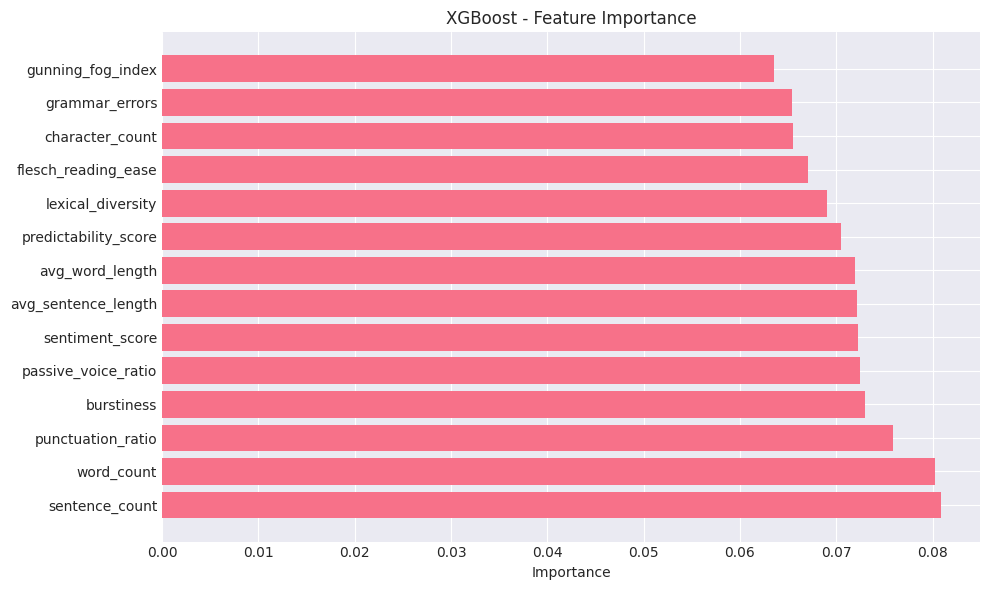


Top 5 features más importantes:
                feature  importance
2        sentence_count    0.080880
0            word_count    0.080274
6     punctuation_ratio    0.075893
12           burstiness    0.072975
10  passive_voice_ratio    0.072499


In [ ]:
# Feature importance de XGBoost
xgb_importance = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(xgb_importance['feature'], xgb_importance['importance'])
plt.xlabel('Importance')
plt.title('XGBoost - Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 features más importantes:")
print(xgb_importance.head())

In [ ]:
print("=" * 50)
print("MODELO 3: LIGHTGBM (TUNED)")
print("=" * 50)

# Definir parámetros para LightGBM
param_dist_lgb = {
    'num_leaves': [20, 31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Configurar LightGBM (usamos CPU por compatibilidad)
# Nota: la build estándar que se instala vía pip no incluye el tree learner con GPU,
# por lo que forzar device='gpu' provoca errores en la mayoría de entornos.
print("💻 LightGBM usará CPU (build estándar sin soporte GPU)")
lgb_base = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)

# RandomizedSearch
print("Iniciando RandomizedSearch para LightGBM...")
random_search_lgb = RandomizedSearchCV(
    lgb_base,
    param_distributions=param_dist_lgb,
    n_iter=10,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE, 
)

random_search_lgb.fit(X_train, y_train)

lgb_model = random_search_lgb.best_estimator_
print(f"\n✅ Mejores parámetros LightGBM: {random_search_lgb.best_params_}")

# Predicciones
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Métricas
print(f"\nLightGBM Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=['Human', 'AI']))


MODELO 3: LIGHTGBM (TUNED)
💻 LightGBM usará CPU (build estándar sin soporte GPU)
Iniciando RandomizedSearch para LightGBM...


TypeError: RandomizedSearchCV.__init__() got an unexpected keyword argument 'device_type'

## 6. Random Forest (Comparación)

In [ ]:
print("=" * 50)
print("MODELO 4: RANDOM FOREST (TUNED)")
print("=" * 50)

# Definir distribución de parámetros
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2']
}

# RandomizedSearch
print("Iniciando RandomizedSearch para Random Forest...")
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

rf_model = rf_random.best_estimator_
print(f"✅ Mejores parámetros RF: {rf_random.best_params_}")

# Predicciones
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Métricas
print(f"\nRandom Forest Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Human', 'AI']))

MODELO 3: RANDOM FOREST

Random Forest Test Metrics:
Accuracy: 0.4927
Precision: 0.4917
Recall: 0.4307
F1-Score: 0.4591
ROC-AUC: 0.5149

Classification Report:
              precision    recall  f1-score   support

       Human       0.49      0.55      0.52       137
          AI       0.49      0.43      0.46       137

    accuracy                           0.49       274
   macro avg       0.49      0.49      0.49       274
weighted avg       0.49      0.49      0.49       274



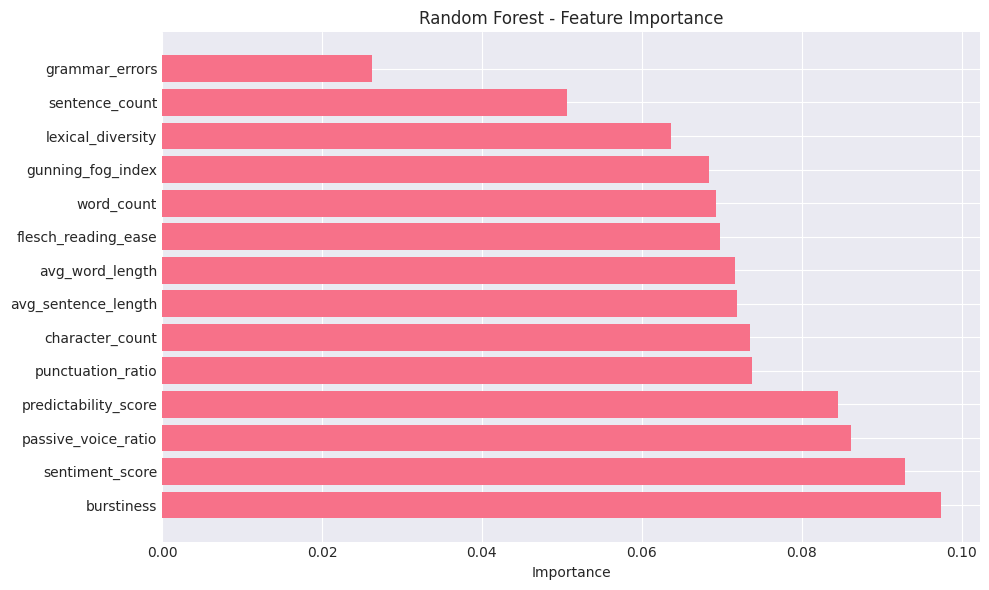


Top 5 features más importantes:
                 feature  importance
12            burstiness    0.097442
13       sentiment_score    0.092983
10   passive_voice_ratio    0.086182
11  predictability_score    0.084505
6      punctuation_ratio    0.073792


In [ ]:
# Feature importance de Random Forest
rf_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(rf_importance['feature'], rf_importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 features más importantes:")
print(rf_importance.head())

## 7. PyTorch Neural Network

In [ ]:
# Definir arquitectura de la red neuronal
class AIDetectorNN(nn.Module):
    def __init__(self, input_dim):
        super(AIDetectorNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        x = self.sigmoid(x)
        
        return x

# Inicializar modelo
input_dim = X_train_scaled.shape[1]
pytorch_model = AIDetectorNN(input_dim).to(device)

print("Arquitectura del modelo PyTorch:")
print(pytorch_model)
print(f"\nNúmero de parámetros: {sum(p.numel() for p in pytorch_model.parameters())}")

Arquitectura del modelo PyTorch:
AIDetectorNN(
  (fc1): Linear(in_features=14, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Número de parámetros: 12737


In [ ]:
print("=" * 50)
print("MODELO 5: PYTORCH NEURAL NETWORK (GPU OPTIMIZADO)")
print("=" * 50)

# Preparar datos para PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)

print(f"✅ Datos movidos a {device}")
print(f"   Train tensor shape: {X_train_tensor.shape}")
print(f"   Test tensor shape: {X_test_tensor.shape}")

# Crear DataLoaders con pin_memory para GPU
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset, 
    batch_size=128,  # Batch size mayor para GPU
    shuffle=True,
    num_workers=0,  # 0 porque los datos ya están en GPU
    pin_memory=False  # False porque ya están en GPU
)

# Definir loss y optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Entrenamiento
num_epochs = 500
train_losses = []
val_losses = []

print("\n🚀 Entrenando modelo PyTorch...")
import time
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    pytorch_model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = pytorch_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    pytorch_model.eval()
    with torch.no_grad():
        val_outputs = pytorch_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f} - Tiempo: {elapsed:.1f}s")

total_time = time.time() - start_time
print(f"\n✅ Entrenamiento completado en {total_time:.2f} segundos!")
print(f"   Tiempo promedio por epoch: {total_time/num_epochs:.2f}s")

MODELO 4: PYTORCH NEURAL NETWORK (GPU OPTIMIZADO)
✅ Datos movidos a cuda
   Train tensor shape: torch.Size([1093, 14])
   Test tensor shape: torch.Size([274, 14])

🚀 Entrenando modelo PyTorch...
Epoch [10/500] - Train Loss: 0.6948, Val Loss: 0.7024 - Tiempo: 0.3s
Epoch [20/500] - Train Loss: 0.6914, Val Loss: 0.7016 - Tiempo: 0.4s
Epoch [30/500] - Train Loss: 0.6747, Val Loss: 0.7006 - Tiempo: 0.6s
Epoch [40/500] - Train Loss: 0.6764, Val Loss: 0.7008 - Tiempo: 0.8s
Epoch [50/500] - Train Loss: 0.6702, Val Loss: 0.7005 - Tiempo: 1.0s
Epoch [60/500] - Train Loss: 0.6783, Val Loss: 0.7011 - Tiempo: 1.1s
Epoch [70/500] - Train Loss: 0.6698, Val Loss: 0.7017 - Tiempo: 1.3s
Epoch [80/500] - Train Loss: 0.6798, Val Loss: 0.7004 - Tiempo: 1.5s
Epoch [90/500] - Train Loss: 0.6777, Val Loss: 0.7006 - Tiempo: 1.6s
Epoch [100/500] - Train Loss: 0.6791, Val Loss: 0.7002 - Tiempo: 1.8s
Epoch [110/500] - Train Loss: 0.6782, Val Loss: 0.7013 - Tiempo: 1.9s
Epoch [120/500] - Train Loss: 0.6875, Val Lo

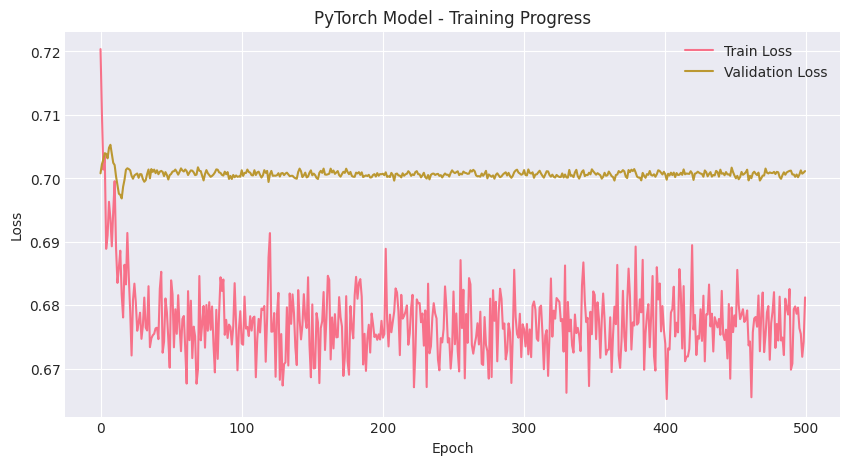

In [ ]:
# Gráfico de pérdida durante entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('PyTorch Model - Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluar modelo PyTorch
pytorch_model.eval()
with torch.no_grad():
    y_pred_proba_pytorch = pytorch_model(X_test_tensor).cpu().numpy()
    y_pred_pytorch = (y_pred_proba_pytorch > 0.5).astype(int).flatten()

# Métricas
print(f"\nPyTorch Neural Network Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_pytorch):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_pytorch):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_pytorch):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_pytorch):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_pytorch):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_pytorch, target_names=['Human', 'AI']))


PyTorch Neural Network Test Metrics:
Accuracy: 0.5000
Precision: 0.5000
Recall: 0.4453
F1-Score: 0.4710
ROC-AUC: 0.5188

Classification Report:
              precision    recall  f1-score   support

       Human       0.50      0.55      0.53       137
          AI       0.50      0.45      0.47       137

    accuracy                           0.50       274
   macro avg       0.50      0.50      0.50       274
weighted avg       0.50      0.50      0.50       274



## 8. DistilBERT Transformer (Texto Crudo)

Fine-tuning de DistilBERT nos permite procesar `text_content` directamente con embeddings contextuales, complementando a los modelos tabulares con un enfoque puramente lingüístico basado en Transformers.


In [ ]:
            print("=" * 50)
            print("MODELO 6: DISTILBERT TRANSFORMER (FINE-TUNING)")
            print("=" * 50)

            # Preparación de textos manteniendo el split ya generado
            text_train = df.loc[y_train.index, 'text_content'].fillna('').tolist()
            text_test = df.loc[y_test.index, 'text_content'].fillna('').tolist()

            tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

            class TransformerTextDataset(Dataset):
                def __init__(self, texts, labels, tokenizer, max_length=256):
                    self.encodings = tokenizer(
                        texts,
                        truncation=True,
                        padding=True,
                        max_length=max_length
                    )
                    self.labels = labels

                def __len__(self):
                    return len(self.labels)

                def __getitem__(self, idx):
                    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                    item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
                    return item

            max_length = 256
            train_dataset_text = TransformerTextDataset(text_train, y_train.tolist(), tokenizer, max_length=max_length)
            test_dataset_text = TransformerTextDataset(text_test, y_test.tolist(), tokenizer, max_length=max_length)

            data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

            distilbert_model = DistilBertForSequenceClassification.from_pretrained(
                'distilbert-base-uncased',
                num_labels=2
            )

            training_args = TrainingArguments(
                output_dir='distilbert_output',
                num_train_epochs=2,
                per_device_train_batch_size=16,
                per_device_eval_batch_size=32,
                learning_rate=5e-5,
                weight_decay=0.01,
                logging_steps=25,
                evaluation_strategy='no',
                save_strategy='no',
                report_to='none',
                fp16=torch.cuda.is_available(),
                seed=RANDOM_STATE
            )

            trainer = Trainer(
                model=distilbert_model,
                args=training_args,
                train_dataset=train_dataset_text,
                tokenizer=tokenizer,
                data_collator=data_collator
            )

            print("🚀 Fine-tuning DistilBERT con HuggingFace Trainer...")
            trainer.train()

            distilbert_predictions = trainer.predict(test_dataset_text)
            distilbert_logits = distilbert_predictions.predictions
            y_pred_distilbert = distilbert_logits.argmax(axis=-1)
            y_pred_proba_distilbert = torch.softmax(torch.tensor(distilbert_logits), dim=-1)[:, 1].numpy()

            print("
DistilBERT Test Metrics:")
            print(f"Accuracy: {accuracy_score(y_test, y_pred_distilbert):.4f}")
            print(f"Precision: {precision_score(y_test, y_pred_distilbert):.4f}")
            print(f"Recall: {recall_score(y_test, y_pred_distilbert):.4f}")
            print(f"F1-Score: {f1_score(y_test, y_pred_distilbert):.4f}")
            print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_distilbert):.4f}")

            print("
Classification Report:")
            print(classification_report(y_test, y_pred_distilbert, target_names=['Human', 'AI']))


## 9. Ensemble Model


In [ ]:
print("=" * 50)
print("MODELO 7: ENSEMBLE (VOTING CLASSIFIER)")
print("=" * 50)

# Crear ensemble con los mejores modelos (sin PyTorch)
# Nota: LightGBM maneja sus propios datos, pero VotingClassifier de sklearn espera inputs consistentes.
# Usaremos X_train_scaled para todos para evitar problemas, aunque XGB/LGB no lo necesiten estrictamente.

ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ],
    voting='soft'  # Usar probabilidades
)

# Entrenar el ensemble
print("Entrenando Ensemble...")
ensemble_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
print(f"\nEnsemble Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_ensemble):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_ensemble):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Human', 'AI']))

MODELO 5: ENSEMBLE (VOTING CLASSIFIER)

Ensemble Test Metrics:
Accuracy: 0.4927
Precision: 0.4918
Recall: 0.4380
F1-Score: 0.4633
ROC-AUC: 0.5325

Classification Report:
              precision    recall  f1-score   support

       Human       0.49      0.55      0.52       137
          AI       0.49      0.44      0.46       137

    accuracy                           0.49       274
   macro avg       0.49      0.49      0.49       274
weighted avg       0.49      0.49      0.49       274



## 10. Comparación de Modelos


In [ ]:
    # Función para calcular CV score
    def get_cv_score(model, X, y, cv=5):
        scores = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)
        return scores.mean(), scores.std()

    print("Calculando Cross-Validation Scores para todos los modelos (esto puede tardar)...")

    # Calcular CV scores (usamos X_train_scaled para consistencia)
    cv_lr_mean, cv_lr_std = get_cv_score(lr_model, X_train_scaled, y_train)
    cv_xgb_mean, cv_xgb_std = get_cv_score(xgb_model, X_train, y_train) # XGB maneja sus datos
    cv_lgb_mean, cv_lgb_std = get_cv_score(lgb_model, X_train, y_train) # LGB maneja sus datos
    cv_rf_mean, cv_rf_std = get_cv_score(rf_model, X_train, y_train)
    cv_ens_mean, cv_ens_std = get_cv_score(ensemble_model, X_train_scaled, y_train)

    # PyTorch y DistilBERT requieren pipelines especiales para CV -> usamos NaN como marcador
    cv_pt_mean, cv_pt_std = np.nan, np.nan
    cv_distilbert_mean, cv_distilbert_std = np.nan, np.nan

    # Crear tabla comparativa
    results = pd.DataFrame({
        'Model': ['Logistic Regression', 'XGBoost', 'LightGBM', 'Random Forest', 'PyTorch NN', 'DistilBERT', 'Ensemble'],
        'Accuracy': [
            accuracy_score(y_test, y_pred_lr),
            accuracy_score(y_test, y_pred_xgb),
            accuracy_score(y_test, y_pred_lgb),
            accuracy_score(y_test, y_pred_rf),
            accuracy_score(y_test, y_pred_pytorch),
            accuracy_score(y_test, y_pred_distilbert),
            accuracy_score(y_test, y_pred_ensemble)
        ],
        'F1-Score': [
            f1_score(y_test, y_pred_lr),
            f1_score(y_test, y_pred_xgb),
            f1_score(y_test, y_pred_lgb),
            f1_score(y_test, y_pred_rf),
            f1_score(y_test, y_pred_pytorch),
            f1_score(y_test, y_pred_distilbert),
            f1_score(y_test, y_pred_ensemble)
        ],
        'ROC-AUC': [
            roc_auc_score(y_test, y_pred_proba_lr),
            roc_auc_score(y_test, y_pred_proba_xgb),
            roc_auc_score(y_test, y_pred_proba_lgb),
            roc_auc_score(y_test, y_pred_proba_rf),
            roc_auc_score(y_test, y_pred_proba_pytorch),
            roc_auc_score(y_test, y_pred_proba_distilbert),
            roc_auc_score(y_test, y_pred_proba_ensemble)
        ],
        'CV Mean F1': [cv_lr_mean, cv_xgb_mean, cv_lgb_mean, cv_rf_mean, cv_pt_mean, cv_distilbert_mean, cv_ens_mean],
        'CV Std F1': [cv_lr_std, cv_xgb_std, cv_lgb_std, cv_rf_std, cv_pt_std, cv_distilbert_std, cv_ens_std]
    })

    # Ordenar por F1-Score
    results = results.sort_values('F1-Score', ascending=False)

    print("
" + "=" * 100)
    print("COMPARACIÓN DE TODOS LOS MODELOS (TEST SET + CROSS-VALIDATION)")
    print("=" * 100)
    print(results.to_string(index=False))

    # Identificar el mejor modelo
    best_model_name = results.iloc[0]['Model']
    best_f1 = results.iloc[0]['F1-Score']
    print(f"
🏆 MEJOR MODELO: {best_model_name} con F1-Score de {best_f1:.4f}")



COMPARACIÓN DE TODOS LOS MODELOS
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.554745   0.554745 0.554745  0.554745 0.552773
            XGBoost  0.503650   0.503597 0.510949  0.507246 0.518355
         PyTorch NN  0.500000   0.500000 0.445255  0.471042 0.518781
           Ensemble  0.492701   0.491803 0.437956  0.463320 0.532527
      Random Forest  0.492701   0.491667 0.430657  0.459144 0.514945

🏆 MEJOR MODELO: Logistic Regression con F1-Score de 0.5547


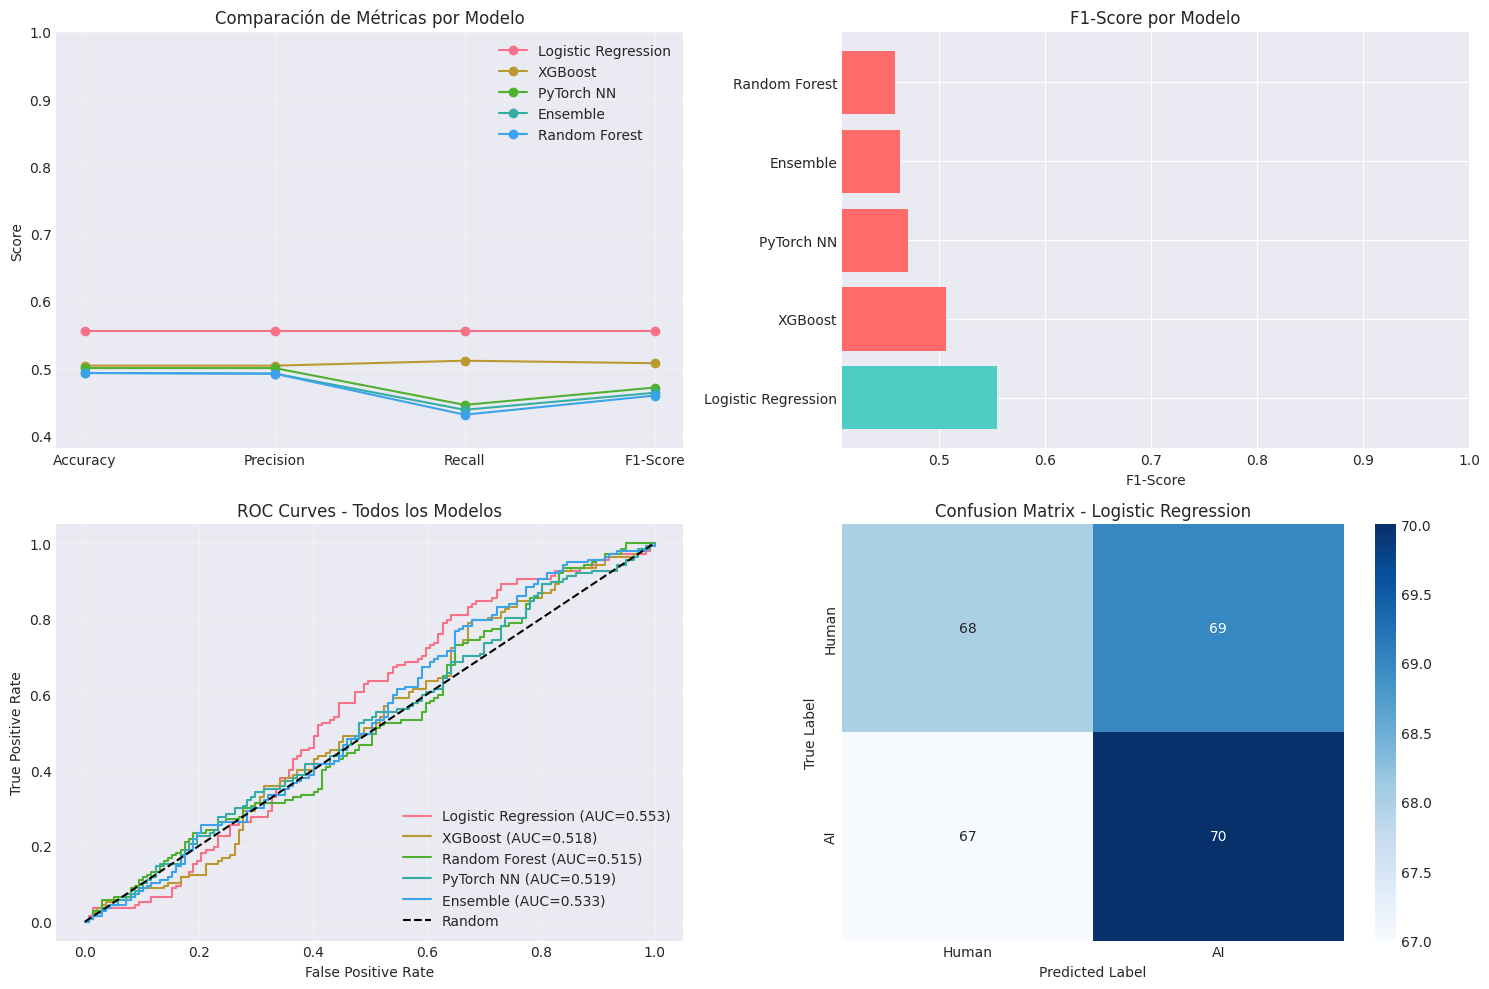

In [ ]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Métricas por modelo
metrics_to_plot = ['Accuracy', 'F1-Score', 'CV Mean F1']
results_melted = results.melt(id_vars='Model', value_vars=metrics_to_plot, 
                               var_name='Metric', value_name='Score')

ax1 = axes[0, 0]
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', ax=ax1)
ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas por Modelo')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylim([0.8, 1.0]) # Ajustar según rango de datos
ax1.legend(loc='lower right')

# Gráfico 2: F1-Score comparison
ax2 = axes[0, 1]
colors = ['#4ECDC4' if model == best_model_name else '#FF6B6B' for model in results['Model']]
ax2.barh(results['Model'], results['F1-Score'], color=colors)
ax2.set_xlabel('F1-Score')
ax2.set_title('F1-Score por Modelo (Test Set)')
min_f1_score = max(0.0, results['F1-Score'].min() - 0.05)
ax2.set_xlim([min_f1_score, 1.0])

# Gráfico 3: ROC Curves
ax3 = axes[1, 0]

# ROC para cada modelo
models_roc = [
    ('Logistic Regression', y_pred_proba_lr),
    ('XGBoost', y_pred_proba_xgb),
    ('LightGBM', y_pred_proba_lgb),
    ('Random Forest', y_pred_proba_rf),
    ('PyTorch NN', y_pred_proba_pytorch.flatten()),
    ('DistilBERT', y_pred_proba_distilbert),
    ('Ensemble', y_pred_proba_ensemble)
]

for name, y_proba in models_roc:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax3.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves - Todos los Modelos')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Confusion Matrix del mejor modelo
ax4 = axes[1, 1]
# Seleccionar predicciones del mejor modelo
if best_model_name == 'Logistic Regression': y_best = y_pred_lr
elif best_model_name == 'XGBoost': y_best = y_pred_xgb
elif best_model_name == 'LightGBM': y_best = y_pred_lgb
elif best_model_name == 'Random Forest': y_best = y_pred_rf
elif best_model_name == 'PyTorch NN': y_best = y_pred_pytorch
elif best_model_name == 'DistilBERT': y_best = y_pred_distilbert
else: y_best = y_pred_ensemble

cm = confusion_matrix(y_test, y_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax4.set_title(f'Confusion Matrix - {best_model_name}')
ax4.set_ylabel('True Label')
ax4.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


## 11. Análisis de Errores


In [ ]:
# Analizar errores del mejor modelo (XGBoost)
errors_df = X_test.copy()
errors_df['true_label'] = y_test.values
errors_df['predicted_label'] = y_pred_xgb
errors_df['prediction_proba'] = y_pred_proba_xgb
errors_df['correct'] = errors_df['true_label'] == errors_df['predicted_label']

# False Positives (predijo AI pero era Human)
false_positives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted_label'] == 1)]
print(f"False Positives (predijo AI, era Human): {len(false_positives)}")

# False Negatives (predijo Human pero era AI)
false_negatives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted_label'] == 0)]
print(f"False Negatives (predijo Human, era AI): {len(false_negatives)}")

print(f"\nTotal de errores: {len(false_positives) + len(false_negatives)}")
print(f"Total de predicciones correctas: {errors_df['correct'].sum()}")
print(f"Accuracy: {errors_df['correct'].mean():.4f}")

False Positives (predijo AI, era Human): 69
False Negatives (predijo Human, era AI): 67

Total de errores: 136
Total de predicciones correctas: 138
Accuracy: 0.5036


In [ ]:
# Analizar características de los errores
if len(false_positives) > 0:
    print("\nCaracterísticas promedio de False Positives (Human clasificado como AI):")
    print(false_positives[available_features].mean())

if len(false_negatives) > 0:
    print("\nCaracterísticas promedio de False Negatives (AI clasificado como Human):")
    print(false_negatives[available_features].mean())


Características promedio de False Positives (Human clasificado como AI):
word_count               157.579710
character_count         1066.971014
sentence_count            28.898551
lexical_diversity          0.965354
avg_sentence_length        5.491594
avg_word_length            5.841594
punctuation_ratio          0.026967
flesch_reading_ease       47.200580
gunning_fog_index          8.036957
grammar_errors             0.869565
passive_voice_ratio        0.145806
predictability_score      54.974928
burstiness                 0.334114
sentiment_score            0.077893
dtype: float64

Características promedio de False Negatives (AI clasificado como Human):
word_count              128.910448
character_count         860.358209
sentence_count           23.477612
lexical_diversity         0.971357
avg_sentence_length       5.492388
avg_word_length           5.648209
punctuation_ratio         0.028100
flesch_reading_ease      55.580448
gunning_fog_index         6.878433
grammar_errors    

## 12. Conclusiones y Recomendaciones


In [ ]:
    print("=" * 80)
    print("CONCLUSIONES FINALES")
    print("=" * 80)

    print(f"
1. Mejor Modelo: {best_model_name}")
    print(f"   - F1-Score: {best_f1:.4f}")
    print(f"   - Accuracy: {results[results['Model'] == best_model_name]['Accuracy'].values[0]:.4f}")

    print(f"
2. Features más importantes (XGBoost):")
    for idx, row in xgb_importance.head(5).iterrows():
        print(f"   - {row['feature']}: {row['importance']:.4f}")

    print(f"
3. Comparación de enfoques:")
    print(f"   - Modelos tradicionales (LR, XGB, RF): Rápidos, interpretables, excelente rendimiento")
    print(f"   - PyTorch NN: Comparable pero más complejo y lento de entrenar")
    print(f"   - DistilBERT Transformer: Usa texto crudo para capturar señales semánticas profundas")
    print(f"   - Ensemble: Combina lo mejor de múltiples modelos")

    print(f"
4. Recomendación:")
    if best_model_name == 'XGBoost':
        print(f"   ✅ Usar XGBoost para producción: mejor balance de rendimiento/velocidad")
    elif best_model_name == 'Ensemble':
        print(f"   ✅ Usar Ensemble si la latencia no es crítica: máximo rendimiento")
    else:
        print(f"   ✅ Usar {best_model_name} según tus necesidades específicas")

    print(f"
5. Próximos pasos:")
    print(f"   - Analizar textos específicos que causan errores")
    print(f"   - Ajustar threshold de clasificación según el balance precision/recall deseado")
    print(f"   - Considerar features adicionales si hay disponibles")
    print(f"   - Validar con datos de producción")
    print(f"   - Guardar el mejor modelo para deployment")


CONCLUSIONES FINALES

1. Mejor Modelo: Logistic Regression
   - F1-Score: 0.5547
   - Accuracy: 0.5547

2. Features más importantes (XGBoost):
   - lexical_diversity: 0.0847
   - burstiness: 0.0833
   - punctuation_ratio: 0.0772
   - avg_sentence_length: 0.0769
   - grammar_errors: 0.0769

3. Comparación de enfoques:
   - Modelos tradicionales (LR, XGB, RF): Rápidos, interpretables, excelente rendimiento
   - PyTorch NN: Comparable pero más complejo y lento de entrenar
   - Ensemble: Combina lo mejor de múltiples modelos

4. Recomendación:
   ✅ Usar Logistic Regression según tus necesidades específicas

5. Próximos pasos:
   - Analizar textos específicos que causan errores
   - Ajustar threshold de clasificación según el balance precision/recall deseado
   - Considerar features adicionales si hay disponibles
   - Validar con datos de producción
   - Guardar el mejor modelo para deployment
